# Red wine explanatory model

## 1. Goal of the analysis

### 1.1 Our goal:

In this project, we will analyze the Red Wine Quality dataset and identify which variables influence perceived wine quality the most by fitting a statistical model in order to understand which factors influence the perceived wine quality.

The stakeholders for this analysis are wine producers and wine marketers. Understanding the factors that influence perceived wine quality can help producers and marketers improve their products, target the right market, and refine their production processes. We will try to identify the most influential physicochemical variables affecting the perceived quality of red wine. This will help us offer actionable insights on the sensory characteristics of wine that most affect quality.

### 1.2 Context and Description:

The dataset is related to red variant of the Portuguese "Vinho Verde" wine. For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

Input variables (based on physicochemical tests):
- **Fixed acidity** - Tartaric acid concentration
- **Volatile acidity** - Acetic acid concentration, linked to smell and vinegar taste
- **Citric acid** - Citric acid concentration, contributing to the wine's freshness
- **Residual sugar** - Sugar left after fermentation
- **Chlorides** - Salt concentration
- **Free sulfur dioxide** - SO2 not bound and available to act as an antimicrobial
- **Total sulfur dioxide** - Total SO2 in wine (bound + free)
- **Density** - Wine density, affected by sugar and alcohol content
- **pH** - Acidity level
- **Sulphates** - Preservatives to prevent spoiling and oxidation, provides protection from bacteria
- **Alcohol** - Alcohol content (% by volume)

Output variable (based on sensory data):
- **Quality** - A score (0–10) representing the sensory quality of the wine

### 1.3 We will check for:

- **Data Quality**: We will inspect the dataset for any missing values, duplicates, and outliers to ensure that the analysis is based on clean data.
- **Correlations between features**: We will explore the relationships between the physicochemical variables and the perceived wine quality score.
- **Multicollinearity**: We will examine the variance inflation factor (VIF) to check for multicollinearity among features.
- **Modeling Approach**: We will use Ordinary Least Squares (OLS) linear regression and logistic regression to predict wine quality and evaluate the explanatory power of the model.
- **Model Performance**: We will assess the model’s performance by analyzing metrics such as R-squared, p-values, residuals, and accuracy in the case of logistic regression.

### 1.4 First, we import the main libraries and create a consistent visual colormap we will use for the analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, r2_score

from utilities import (
    find_missing_values,
    find_outliers,
    build_ols_model,
    build_logistic_model,
    plot_confusion_matrix,
    plot_model_residuals,
    plot_features,
    check_vif,
    plot_corr_matrix,
)

In [2]:
pd.set_option("display.max_colwidth", None)
plt.rcParams["figure.figsize"] = (10, 6)
colors = ["#ca0020", "#f4a582", "#92c5de", "#0571b0"]
sns.set_theme(style="white")
sns.set_palette(sns.color_palette(colors))

## 2. Cleaning and inspecting data

### 2.1 We import the dataset and take a look at it

In [3]:
df = pd.read_csv("winequality-red.csv")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


We seem to have 1599 rows with 12 features each

### 2.2 We check for any missing values

In [4]:
find_missing_values(df)

,Zeroes,Empty Strings,NaN
fixed acidity,0,0,0
volatile acidity,0,0,0
citric acid,132,0,0
residual sugar,0,0,0
chlorides,0,0,0
free sulfur dioxide,0,0,0
total sulfur dioxide,0,0,0
density,0,0,0
pH,0,0,0
sulphates,0,0,0


Citric acid is not used in all wines, therefore it makes sense that some wines have 0 values in it.

### 2.3 We check for any duplicate entries

In [5]:
print(f"There are {df.duplicated().sum()} duplicate rows.")

There are 240 duplicate rows.


We have 240 duplicates, indicating possible faults in data gathering. We will remove them.

In [6]:
df = df[~df.duplicated()]

### 2.4 Let's check for any outliers in numerical fields using the IQR method

In [7]:
numeric = [feature for feature in df if df[feature].dtype in ["int64", "float64"]]
outliers = find_outliers(df, numeric)
outliers

**Feature-wise Outlier Analysis**

,Feature Name,Outliers,Percentage,IQR Bounds,Flagged Values
0,fixed acidity,41,3.02%,"[3.95, 12.35]","[12.40, 15.90]"
1,volatile acidity,19,1.40%,"[0.02, 1.02]","[1.02, 1.58]"
2,citric acid,1,0.07%,"[-0.42, 0.94]","[1.00, 1.00]"
3,residual sugar,126,9.27%,"[0.85, 3.65]","[3.70, 15.50]"
4,chlorides,87,6.40%,"[0.04, 0.12]","[0.01, 0.61]"
5,free sulfur dioxide,26,1.91%,"[-14.00, 42.00]","[43.00, 72.00]"
6,total sulfur dioxide,45,3.31%,"[-39.50, 124.50]","[125.00, 289.00]"
7,density,35,2.58%,"[0.99, 1.00]","[0.99, 1.00]"
8,pH,28,2.06%,"[2.92, 3.68]","[2.74, 4.01]"
9,sulphates,55,4.05%,"[0.28, 1.00]","[1.00, 2.00]"


**All Outliers**

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
9,7.5,0.500,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
13,7.8,0.610,0.29,1.6,0.114,9.0,29.0,0.99740,3.26,1.56,9.1,5
14,8.9,0.620,0.18,3.8,0.176,52.0,145.0,0.99860,3.16,0.88,9.2,5
15,8.9,0.620,0.19,3.9,0.170,51.0,148.0,0.99860,3.17,0.93,9.2,5
17,8.1,0.560,0.28,1.7,0.368,16.0,56.0,0.99680,3.11,1.28,9.3,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1570,6.4,0.360,0.53,2.2,0.230,19.0,35.0,0.99340,3.37,0.93,12.4,6
1571,6.4,0.380,0.14,2.2,0.038,15.0,25.0,0.99514,3.44,0.65,11.1,6
1574,5.6,0.310,0.78,13.9,0.074,23.0,92.0,0.99677,3.39,0.48,10.5,6
1577,6.2,0.700,0.15,5.1,0.076,13.0,27.0,0.99622,3.54,0.60,11.9,6


In [8]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


<Axes: >

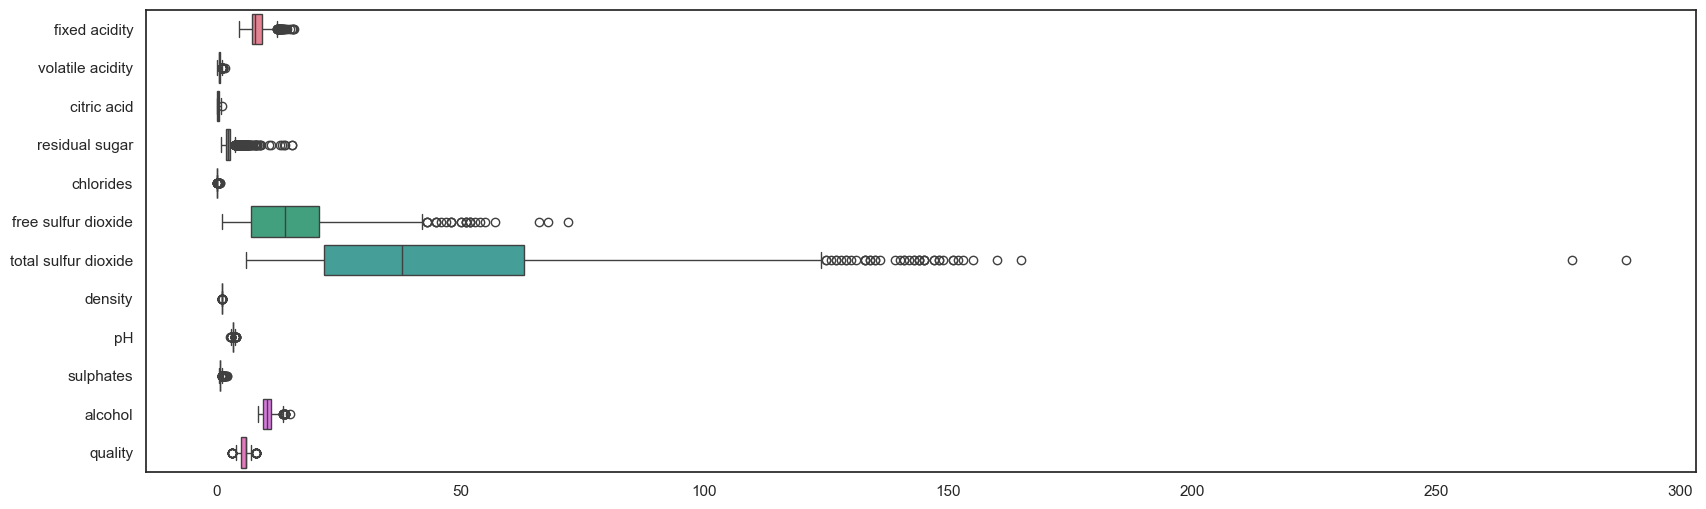

In [9]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=df, orient="h")

We can see very high values of **total sulfur dioxide** in 2 cases. While the legal limit for this feature in US is 350 mg/L, the limit in EU is only 150 mg/l (we are looking at Portuguese wine data), therefore these values should not be valid and we will remove them.

In [10]:
df = df[df["total sulfur dioxide"] <= 150]

### 2.6 Let's look at each feature individually - their distribution and relationship with our dependent variable

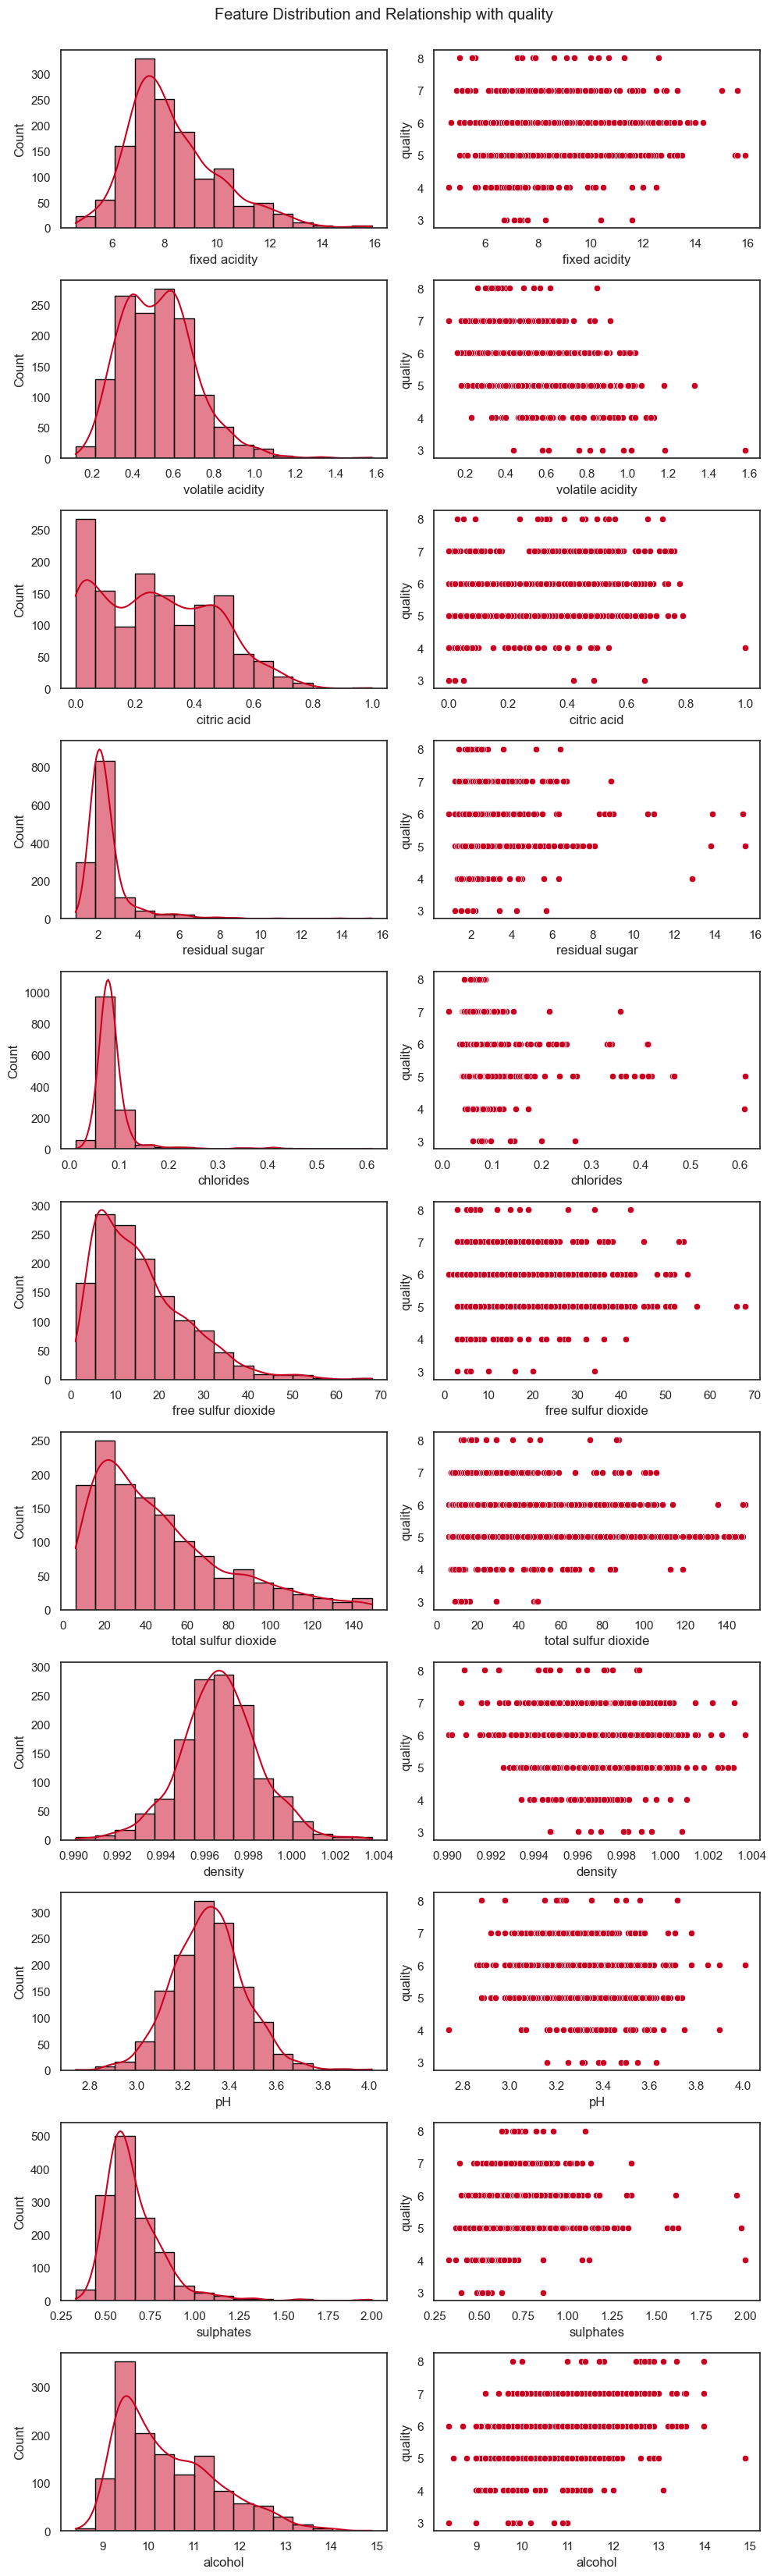

In [11]:
plot_features(df, "quality")

We can see that most features follow a normal or a right-skewed distribution. At a glimpse, it also seems like **alchohol** and **sulphates** have a positive relationship with **quality**.

### 2.7 Let's look at the correlations between features

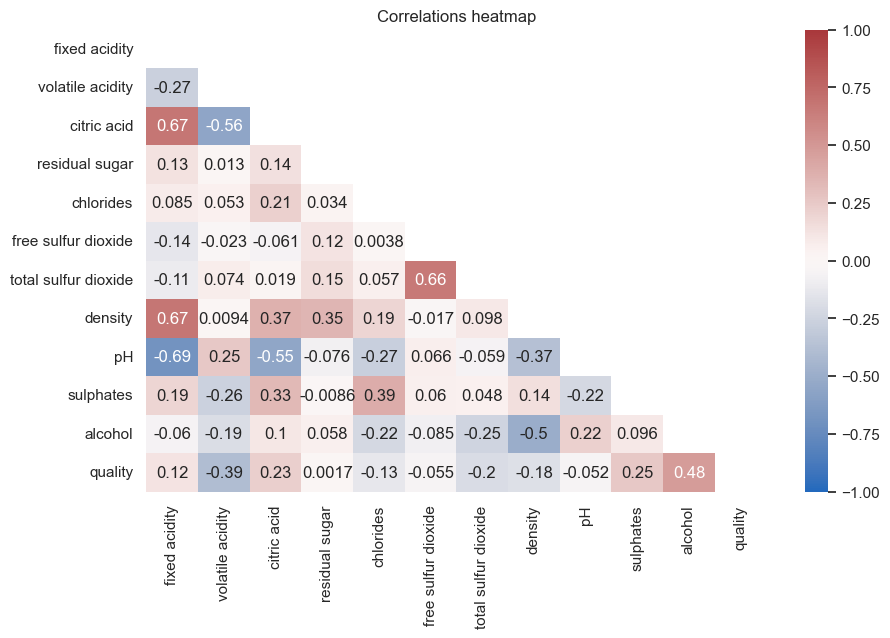

In [12]:
plot_corr_matrix(df)

**Positive correlations of interest:**
- quality - alcohol (0.48)
- quality - sulphates (0.25)
- quality - citric acid(0.23)

**Negative correlations of interest:**
- quality - volatile acidity (-0.39)

### 2.8 Based on these correlations, we will formulate our hypotheses:

**H0 (Null Hypothesis)**: Alcohol has no impact on the perceived quality of wine

**Ha (Alternative Hypothesis)**: Higher alcohol content **increases** perceived wine quality

**H0 (Null Hypothesis)**: Sulphates have no impact on the perceived quality of wine

**Ha (Alternative Hypothesis)**: Higher sulphates content **increases** perceived wine quality

**H0 (Null Hypothesis)**: Volatile acidity has no impact on the perceived quality of wine

**Ha (Alternative Hypothesis)**: Higher volatile acidity content **decreases** perceived wine quality


**α = 0.05 (5%)**

## 3. Modelling

### 3.1 Checking for multicollinearity using VIF (variance inflation factor)

In [13]:
check_vif(df, "quality")

                 Feature   VIF
0          fixed acidity  7.92
1       volatile acidity  1.79
2            citric acid  3.13
3         residual sugar  1.63
4              chlorides  1.53
5    free sulfur dioxide  1.93
6   total sulfur dioxide  2.17
7                density  6.36
8                     pH  3.38
9              sulphates  1.47
10               alcohol  3.16


It seems like **density** and **fixed acidity** have higher VIF values than norm (>5), indicating that these features have correlation with other independent features. This can negatively affect the regression results, therefore we will remove one of them and check for multicollinearity again.

In [14]:
check_vif(df, ["quality", "density"])

                Feature   VIF
0         fixed acidity  3.01
1      volatile acidity  1.77
2           citric acid  3.13
3        residual sugar  1.08
4             chlorides  1.52
5   free sulfur dioxide  1.92
6  total sulfur dioxide  2.15
7                    pH  2.32
8             sulphates  1.39
9               alcohol  1.34


Now the VIF values are within expected range. During modelling, we will still initially keep all independent variables just to quickly glance at their significance levels, but we'll make sure **density** is not used in our final model.

### 3.2 We will use the OLS (Ordinary Least Squares) linear regression model

We will standardize features by removing the mean and scaling to unit variance (using **Standard Scaler**). This method is more suited for our data since it is more robust to outliers and works well for normal or right-skewed distributions.

Several engineered features, including **alcohol/density interaction** and **sugar to acid ratio** were tested. However, they were excluded from the model due to non-significant p-values and lack of improvement in model performance.

In [15]:
ols_model, X_test, y_test = build_ols_model(df, [], "quality")
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     53.36
Date:                Mon, 20 Jan 2025   Prob (F-statistic):           9.42e-94
Time:                        12:09:59   Log-Likelihood:                -1061.7
No. Observations:                1080   AIC:                             2147.
Df Residuals:                    1068   BIC:                             2207.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6296 

Our initial model shows an **adjusted R-squared** value of 0.348, meaning 34.8% of the variation on the dependent variable is explained by our independent variables in the model (after adjusting for the number of predictors in the model). We will try to increase this value by removing non-significant predictors from the model.

### 3.3 Model refinement

After removing the most non-significant (**p-value < 0.10**) features iteratively one by one (making sure the **Adj. R-Squared** feature does not get lower each time), we are left with our final model.

In [16]:
ols_model, X_test, y_test = build_ols_model(
    df, ["residual sugar", "citric acid", "density", "fixed acidity"], "quality"
)
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     83.90
Date:                Mon, 20 Jan 2025   Prob (F-statistic):           3.09e-97
Time:                        12:09:59   Log-Likelihood:                -1062.3
No. Observations:                1080   AIC:                             2141.
Df Residuals:                    1072   BIC:                             2180.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6296 

Our final model results are:

- **R-squared (0.354)**:

Indicates that about 35.4% of the variance in wine quality is explained by the independent variables. While this suggests some explanatory power, the relatively low value implies other factors influencing quality are not captured in the model.

- **Adjusted R-squared (0.350)**:

Adjusted R-squared accounts for the number of predictors, and since it's close to the R-squared value, it suggests the included predictors are meaningful.

- **F-statistic (83.90, p-value < 0.001)**:

A highly significant F-statistic means that the model as a whole is statistically significant, and at least one predictor has a meaningful relationship with wine quality.


Largest impact on **quality**:
- **alcohol** with the largest positive effect, with 1 **standard deviation** increase resulting in a 0.2934-point increase in **quality**. 
- **volatile acidity** with the largest negative effect, with 1 **standard deviation** increase resulting in a 0.1864-point decrease in **quality**. 

Besides these variables, **sulphates**, **total sulfur dioxide**, **pH** and **chlorides** also seem to have a statistically significant importance in perceived **quality** value.

### 3.4 Answering hypotheses

- With a **p-value** < 0.05, we **reject** the null hypothesis that **alcohol** has no impact on the perceived wine quality. For every 1 **standard deviation** increase in **alcohol**, the **quality** increases by 0.2934 units, with a **95% CI** of **[0.250 - 0.337]**
- With a **p-value** < 0.05, we **reject** the null hypothesis that **sulphates** have no impact on the perceived wine quality. For every 1 **standard deviation** increase in **sulphates**, the **quality** increases by 0.1492 units, with a **95% CI** of **[0.104 - 0.194]**
- With a **p-value** < 0.05, we **reject** the null hypothesis that **volatile acidity** has no impact on the perceived wine quality. For every 1 **standard deviation** increase in **volatile acidity**, the **quality** decreases by 0.1864 units, with a **95% CI** of **[-0.229 - -0.143]**

### 3.5 Inspecting model performance

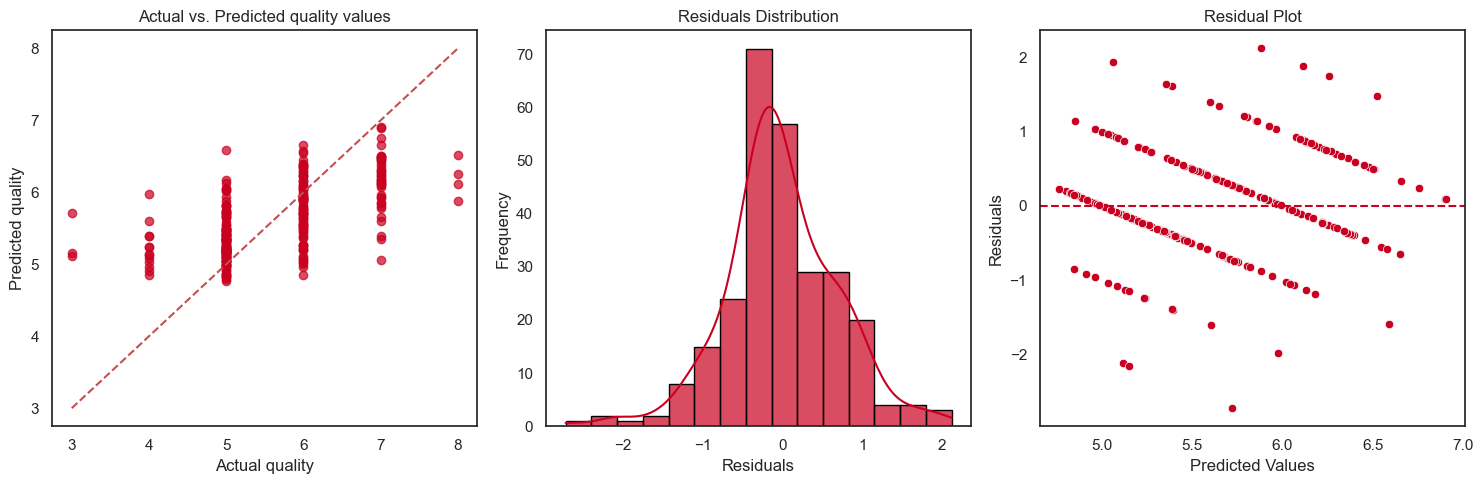

Train R^2: 0.354
Test R^2: 0.387


In [17]:
y_pred_lin = ols_model.predict(X_test)
plot_model_residuals(y_test, y_pred_lin)

r2_train = ols_model.rsquared
r2_test = r2_score(y_test, y_pred_lin)
print(f"Train R^2: {r2_train:.3f}")
print(f"Test R^2: {r2_test:.3f}")

From what we see, it seems like the model is underfitting, as the predicted points don't align well with the model line, indicating that predictions don't match the actual values well, especially for lower and higher ranges of quality. Predictions are biased towards the mean value of 5-6.

We can assume that the model performed poorly because the relationship between features and wine quality might be **non-linear**, while linear regression assumes linearity.

Residual frequency seems to be distributed at around 0 with an approximately normal distribution, suggesting that the model errors are unbiased.

We can also see distinct horizontal bands, indicating that our dependent variable is categorical, while the model predicts continuous variables. Residuals are not randomly scattered around 0, again indicating that linear regression might not be appropriate for this task.

The difference in **R^2** between train and test data seems small, suggesting that the model generalizes well and performs slightly better on the test data.

### 3.6 Logistic model performance comparison

To see whether a logistic model could solve the classification problem better, we will compare the results to our previous linear model. While the metrics we will use (such as the ones in classification report and confusion matrices) are generally not used for logistic regression model summarization, it can give us a quick hint towards possible further analysis.

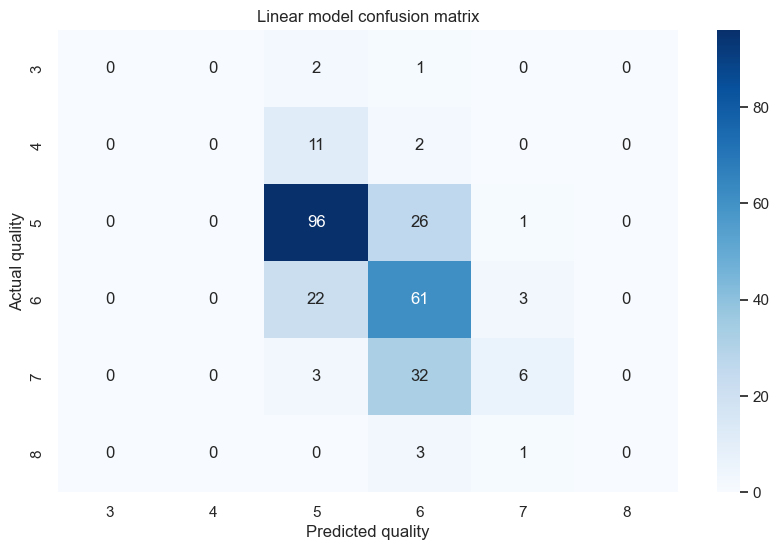

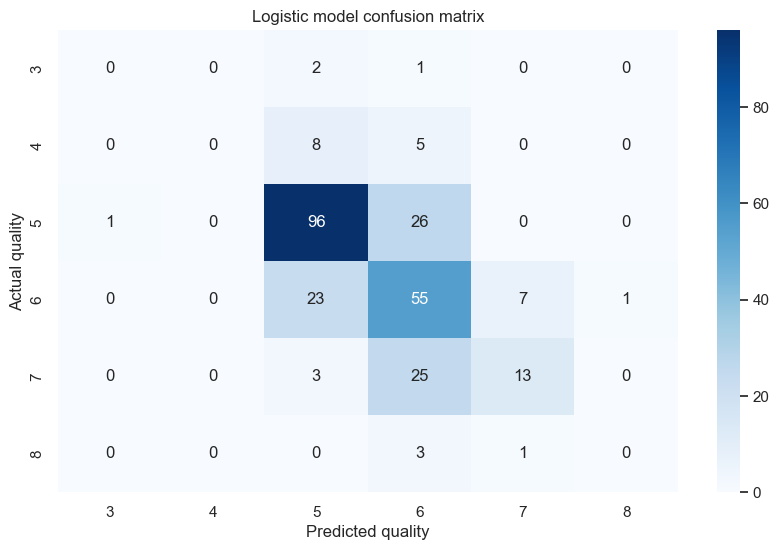

Linear model classification report: 

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        13
           5       0.72      0.78      0.75       123
           6       0.49      0.71      0.58        86
           7       0.55      0.15      0.23        41
           8       0.00      0.00      0.00         4

    accuracy                           0.60       270
   macro avg       0.29      0.27      0.26       270
weighted avg       0.56      0.60      0.56       270

Logistic model classification report: 

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        13
           5       0.73      0.78      0.75       123
           6       0.48      0.64      0.55        86
           7       0.62      0.32      0.42        41
           8       0.00      0.00      0.00         4


In [18]:
logreg, X_test, y_test = build_logistic_model(df, "quality")
y_pred_log = logreg.predict(X_test)

y_pred_lin = np.round(y_pred_lin).astype(int)
y_pred_lin = np.clip(y_pred_lin, min(y_test), max(y_test))
unique_labels = sorted(y_test.unique())

plot_confusion_matrix(y_test, y_pred_lin, unique_labels, "Linear")
plot_confusion_matrix(y_test, y_pred_log, logreg.classes_, "Logistic")

class_rep_linear = classification_report(y_test, y_pred_lin, zero_division=0)
class_rep_logistic = classification_report(y_test, y_pred_log, zero_division=0)
print(f"Linear model classification report: \n\n{class_rep_linear}")
print(f"Logistic model classification report: \n\n{class_rep_logistic}")

- Logistic regression slightly outperforms linear regression in terms of overall accuracy (61% compared to 60%)
- For **quality** 3, 4 and 8 wines, no predictions were made. We can also see that we had the least samples in those categories.
- For **quality 5**, both models perform relatively well, with logistic regression slightly better (73% precision compared to 72%, both with 78% recall). It is the most accurate category with the most samples.
- **Quality** 6 had moderate performance in both models.
- Logistic regression seems to classify **quality 7** wines considerably better than linear regression, with F1-score of 0.42 compared to 0.23.

We see that logistic regression has generally better performance (although not by much), since it is designed for classification tasks by predicting probabilities. Furthermore, since quality 3, 4 and 8 wines had very few instances in the dataset, both models had difficulty learning any meaningful patterns for them and could not provide accurate results.

## 4. Results

### Findings:

Our analysis identified several key factors influencing the perceived quality of red wine:

- **Alcohol** was found to have a **strong positive** effect on wine quality.
- **Volatile acidity** showed the largest **negative impact** on wine quality.
- **Sulphates, total sulfur dioxide, pH, and chlorides** were also found to be significant predictors of perceived wine quality.
- The final model's **adjusted R-squared value of 0.350** indicates that about 35% of the variation in wine quality is explained by the selected features.

While the model shows some explanatory power, the relatively low R-squared value suggests that other factors affecting wine quality, which are not captured in the dataset, may also play an important role.

### Answers to Goals and Stakeholder Needs:

- **For wine producers**: The key factors influencing wine quality are alcohol content and volatile acidity. Adjusting these factors can have a noticeable impact on the perceived quality of wine.
- **For marketers**: Emphasizing alcohol content in promotional material could appeal to consumers who value stronger wines.

## 5. Future improvements

- **Balance the dataset**:
Address the class imbalance in wine quality categories using oversampling or undersampling techniques. This could help improve model performance, especially for quality classes with fewer instances.

- **Feature engineering**:
Explore additional feature transformations such as polynomial or interaction terms to better capture non-linear relationships between the features and wine quality.

- **Binomial logistic regression**:
Try transforming the wine quality into two categories (e.g., "average" and "good") based on a set quality threshold. This could simplify the problem and provide better classification performance.

- **Non-linear models**:
Given the poor performance of the linear regression model, we could try non-linear models such as decision trees, random forests, or gradient boosting to capture the complexities of the relationship between features and quality.